# Library

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedGroupKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer # IterativeImputer,
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, roc_curve
)

import csv
import matplotlib.pyplot as plt
import os


# Preprocess

In [7]:
def f_read_file(file_name):
    ''' Read location csv / xlsx   '''
    print('=== Starting Reading === ')

    if file_name.endswith("csv"):
        df = pd.read_csv(file_name, header=0)
    else:
        df = pd.read_excel(file_name, header=0)
    
    df = df.drop_duplicates(keep='first')
    print(df.columns, '\n')
    print(f"The input data shape: {df.shape[0]}")
    return df


# One-hot encode categorical features
def preprocess_data(df):
    df = pd.get_dummies(df, columns=['placenta_cat', 'baby_gender'])
    return df


In [8]:
def get_next_filename(base_filename, folder='./evaluation_result/'):
    files = os.listdir(folder)
    
    matching_files = [f for f in files if f.startswith(base_filename)]
    
    if matching_files:
        numbers = [int(f.split('_')[-1].split('.')[0]) for f in matching_files if '_' in f]
        next_number = max(numbers) + 1
    else:
        next_number = 1
    
    next_filename = f"{base_filename}_{next_number}.csv"
    return os.path.join(folder, next_filename)


def fit_and_evaluate(X_train, X_test, y_train, y_test, methods, model_name='lr',  csv_filename='./evaluation_result/model_evaluation_results.csv'):
    ''' modeling and evaluation, 'model_name' is the notes inside of saving csv'''
    
    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    bal_acc = round(balanced_accuracy_score(y_test, y_pred), 4)
    roc_auc = round(roc_auc_score(y_test, y_proba), 4)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = round(tn / (tn + fp), 4)
    npv = round(tn / (tn + fn), 4)
    
    # Compute true positive rate (sensitivity) for 10% FPR
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    results = {
        'Method' : methods,
        'Model': model_name,

        'Precision': precision,
        'Negative Predictive Value': npv,
        'Recall': recall,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'F1 Score': f1,

        'Balanced Accuracy': bal_acc,
        'ROC AUC': roc_auc,
    }

    # Print results
    print(f"'Method': {methods}, Model: {model_name}")
    for key, value in results.items():
        if (key != 'Model') & (key == 'ROC AUC'):
            print(f"{key}: {value}")
    # print("="*50)

        

    # Write to CSV
    file_exists = False
    directory = './evaluation_result/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        with open(csv_filename, 'r') as csvfile:
            file_exists = True
    except FileNotFoundError:
        file_exists = False

    with open(csv_filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=results.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(results)



models = {
    'lr': LogisticRegression(class_weight='balanced', random_state=123), # , max_iter=300
    'knn': KNeighborsClassifier(),
    'svcrbf': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=123), # rbf
    'rf': RandomForestClassifier(class_weight='balanced', random_state=123),
    'xgb': XGBClassifier(random_state=123), #scale_pos_weight=2.26  1
    'lgbm': LGBMClassifier(class_weight='balanced', random_state=123, verbose=0),
    'catboost': CatBoostClassifier(class_weights=[1, 1], random_state=123, verbose=0),
    'mlp': MLPClassifier(random_state=123)
}


# Read file

In [9]:
file_name = f"./preprocessing/df_tri2_12w28w_drop_death_train_bw.csv"
df_read = f_read_file(file_name)
print()
df_read.count_id.unique().shape  

# remove illegitimate features
df_read = df_read.drop(columns=['birth_ga', 'birth_weight']) 
df_read.info()

=== Starting Reading === 
Index(['count_id', 'ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd',
       'm_age', 'placenta_cat', 'baby_gender', 'WHO_cur_sga', 'WHO_sga',
       'birth_ga', 'birth_weight'],
      dtype='object') 

The input data shape: 4970

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4970 entries, 0 to 4969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   count_id      4970 non-null   int64  
 1   ga            4970 non-null   float64
 2   efw           4970 non-null   float64
 3   bpd           4970 non-null   float64
 4   hc            4970 non-null   float64
 5   ac            4970 non-null   float64
 6   fl            4970 non-null   float64
 7   nf            4970 non-null   float64
 8   cm            4970 non-null   float64
 9   tcd           4970 non-null   float64
 10  m_age         4970 non-null   float64
 11  placenta_cat  4970 non-null   object 
 12  baby_gender   4970 non-

In [10]:
df = df_read.copy()
df = preprocess_data(df)

df.shape, df.columns

((4970, 17),
 Index(['count_id', 'ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd',
        'm_age', 'WHO_cur_sga', 'WHO_sga', 'placenta_cat_Low_Lying',
        'placenta_cat_Upper_Segment', 'baby_gender_BOY', 'baby_gender_GIRL'],
       dtype='object'))

# TASKS

## [L1.1a] Resampling

In [14]:
# Imbalance handling
def handle_imbalance(X, y, method='ROS'):
    print(f'{method} is using.')
    if method == 'SMOTE':
        sampler = SMOTE(random_state=123)
    elif method == 'ROS':
        sampler = RandomOverSampler(random_state=123)
    elif method == 'ADASYN':
        sampler = ADASYN(random_state=123)
    elif method == 'RUS':
        sampler = RandomUnderSampler(random_state=123)
    else:
        print('********** There is not methods to handle imbalance in Sampling Spliting')
        return X, y
        raise ValueError("Unknown method: " + method)
    X_res, y_res = sampler.fit_resample(X, y)
    return X_res, y_res



# Split data and apply imbalance handling after split
def imbalance_after_split(df, method):
    X = df.drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id'])
    y = df['WHO_sga']
    print(X.columns)
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
    train_index, test_index = next(sss.split(X, y))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_res, y_train_res = handle_imbalance(X_train, y_train, method)  # Change method as needed
    
    return X_train_res, X_test, y_train_res, y_test



# Split data and apply imbalance handling before split
def imbalance_before_split(df, method):
    X = df.drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id'])
    y = df['WHO_sga']
    print(X.columns)
    
    X_res, y_res = handle_imbalance(X, y, method)  # Change method as needed
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
    train_index, test_index = next(sss.split(X_res, y_res))
    
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
    
    return X_train, X_test, y_train, y_test

In [7]:
df = df_read.copy()
df = preprocess_data(df)

df = df.drop_duplicates(subset='count_id', keep='first')
df.shape, df.WHO_sga.value_counts()

# ((4749, 17),
# WHO_sga
#  0    3295
#  1    1454

((4749, 17),
 WHO_sga
 0    3295
 1    1454
 Name: count, dtype: int64)

### proper

In [10]:
# correct
# Split data and apply imbalance handling after split
methods = ['ROS', 'SMOTE', 'ADASYN', 'RUS', 'None']

for method in methods:
    X_train, X_test, y_train, y_test = imbalance_after_split(df, method)  # imbalance_after_split(df)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    # Evaluate all models
    for model_name in models.keys():
        fit_and_evaluate(X_train, X_test, y_train, y_test, methods=method, model_name=model_name, csv_filename='./evaluation_result/L1.1a_proper.csv')

Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
ROS is using.
'Method': ROS, Model: lr
ROC AUC: 0.764


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': ROS, Model: knn
ROC AUC: 0.6212
'Method': ROS, Model: svcrbf
ROC AUC: 0.6593
'Method': ROS, Model: rf
ROC AUC: 0.7366
'Method': ROS, Model: xgb
ROC AUC: 0.7024
'Method': ROS, Model: lgbm
ROC AUC: 0.7353
'Method': ROS, Model: catboost
ROC AUC: 0.7408
'Method': ROS, Model: mlp
ROC AUC: 0.74
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
SMOTE is using.
'Method': SMOTE, Model: lr
ROC AUC: 0.7522


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': SMOTE, Model: knn
ROC AUC: 0.6092
'Method': SMOTE, Model: svcrbf
ROC AUC: 0.6579
'Method': SMOTE, Model: rf
ROC AUC: 0.7117
'Method': SMOTE, Model: xgb
ROC AUC: 0.721
'Method': SMOTE, Model: lgbm
ROC AUC: 0.7376
'Method': SMOTE, Model: catboost
ROC AUC: 0.7345
'Method': SMOTE, Model: mlp
ROC AUC: 0.74
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
ADASYN is using.
'Method': ADASYN, Model: lr
ROC AUC: 0.7517


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': ADASYN, Model: knn
ROC AUC: 0.6084
'Method': ADASYN, Model: svcrbf
ROC AUC: 0.6536
'Method': ADASYN, Model: rf
ROC AUC: 0.7074
'Method': ADASYN, Model: xgb
ROC AUC: 0.7044
'Method': ADASYN, Model: lgbm
ROC AUC: 0.7304
'Method': ADASYN, Model: catboost
ROC AUC: 0.7384
'Method': ADASYN, Model: mlp
ROC AUC: 0.7479
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
RUS is using.
'Method': RUS, Model: lr
ROC AUC: 0.764


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': RUS, Model: knn
ROC AUC: 0.6074
'Method': RUS, Model: svcrbf
ROC AUC: 0.6265
'Method': RUS, Model: rf
ROC AUC: 0.7165
'Method': RUS, Model: xgb
ROC AUC: 0.7021
'Method': RUS, Model: lgbm
ROC AUC: 0.7245
'Method': RUS, Model: catboost
ROC AUC: 0.7499
'Method': RUS, Model: mlp
ROC AUC: 0.663
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
None is using.
********** There is not methods to handle imbalance in Sampling Spliting
'Method': None, Model: lr
ROC AUC: 0.7669


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': None, Model: knn
ROC AUC: 0.6252
'Method': None, Model: svcrbf
ROC AUC: 0.6408
'Method': None, Model: rf
ROC AUC: 0.725
'Method': None, Model: xgb
ROC AUC: 0.7255
'Method': None, Model: lgbm
ROC AUC: 0.7379
'Method': None, Model: catboost
ROC AUC: 0.7499
'Method': None, Model: mlp
ROC AUC: 0.7352


### improper

In [11]:
# incorrect
# Split data and apply imbalance handling before split
methods = ['ROS', 'SMOTE', 'ADASYN', 'RUS'] # , 'None'

for method in methods:
    X_train, X_test, y_train, y_test = imbalance_before_split(df, method)  # imbalance_after_split(df)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    # Evaluate all models
    for model_name in models.keys():
        fit_and_evaluate(X_train, X_test, y_train, y_test, methods=method, model_name=model_name, csv_filename='./evaluation_result/L1.1a_improper.csv')

Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
ROS is using.
'Method': ROS, Model: lr
ROC AUC: 0.7428


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': ROS, Model: knn
ROC AUC: 0.7145
'Method': ROS, Model: svcrbf
ROC AUC: 0.6327
'Method': ROS, Model: rf
ROC AUC: 0.9398
'Method': ROS, Model: xgb
ROC AUC: 0.8836
'Method': ROS, Model: lgbm
ROC AUC: 0.8502
'Method': ROS, Model: catboost
ROC AUC: 0.8477
'Method': ROS, Model: mlp
ROC AUC: 0.7169
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
SMOTE is using.
'Method': SMOTE, Model: lr
ROC AUC: 0.8036


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': SMOTE, Model: knn
ROC AUC: 0.7794
'Method': SMOTE, Model: svcrbf
ROC AUC: 0.6507
'Method': SMOTE, Model: rf
ROC AUC: 0.8968
'Method': SMOTE, Model: xgb
ROC AUC: 0.8769
'Method': SMOTE, Model: lgbm
ROC AUC: 0.8833
'Method': SMOTE, Model: catboost
ROC AUC: 0.8838
'Method': SMOTE, Model: mlp
ROC AUC: 0.8323
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
ADASYN is using.


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': ADASYN, Model: lr
ROC AUC: 0.8173
'Method': ADASYN, Model: knn
ROC AUC: 0.756
'Method': ADASYN, Model: svcrbf
ROC AUC: 0.6258
'Method': ADASYN, Model: rf
ROC AUC: 0.8983
'Method': ADASYN, Model: xgb
ROC AUC: 0.8739
'Method': ADASYN, Model: lgbm
ROC AUC: 0.8862
'Method': ADASYN, Model: catboost
ROC AUC: 0.8862
'Method': ADASYN, Model: mlp
ROC AUC: 0.83
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
RUS is using.
'Method': RUS, Model: lr
ROC AUC: 0.6898


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': RUS, Model: knn
ROC AUC: 0.5938
'Method': RUS, Model: svcrbf
ROC AUC: 0.5799
'Method': RUS, Model: rf
ROC AUC: 0.684
'Method': RUS, Model: xgb
ROC AUC: 0.6826
'Method': RUS, Model: lgbm
ROC AUC: 0.6866
'Method': RUS, Model: catboost
ROC AUC: 0.7036
'Method': RUS, Model: mlp
ROC AUC: 0.6609
Index(['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age',
       'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment',
       'baby_gender_BOY', 'baby_gender_GIRL'],
      dtype='object')
None is using.
********** There is not methods to handle imbalance in Sampling Spliting
'Method': None, Model: lr
ROC AUC: 0.7669


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': None, Model: knn
ROC AUC: 0.6252
'Method': None, Model: svcrbf
ROC AUC: 0.6408
'Method': None, Model: rf
ROC AUC: 0.725
'Method': None, Model: xgb
ROC AUC: 0.7255
'Method': None, Model: lgbm
ROC AUC: 0.7379
'Method': None, Model: catboost
ROC AUC: 0.7499
'Method': None, Model: mlp
ROC AUC: 0.7352


In [ ]:
# results_df = pd.read_csv('model_evaluation_results.csv')
# results_df[-21:]

## [L1.1b] Imputation

In [15]:
# Function to split data
def split_data_sgkf(df):
    X = df.drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id'])
    y = df['WHO_sga']
    # print(X.columns)
    
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)
    train_index, test_index = next(sgkf.split(X, y, groups=df.count_id))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, X_test, y_train, y_test


def remove_features(X, N):
    if N != 0:
        np.random.seed(123)
        # X = pd.DataFrame(X)
        cols = list(X.columns)
        for index in range(X.shape[0]):
            cols_to_nan = np.random.choice(cols, N, replace=False)
            X.loc[index, cols_to_nan] = np.nan
        X = X.dropna(how='all')
    return X


# Function to impute missing values
def impute_missing_values(method, X_train):
    if method == 'mean':
        ga_col = 'ga'
        # if ga_col not in X.columns:
        #     raise ValueError(f"Column '{ga_col}' not found in dataframe")
        for col in X_train.columns:
            if col != ga_col:
                means = X_train.groupby(ga_col)[col].transform('mean')
                X_train = X_train.fillna(means)
            else:
                means = X_train.mean()
                X_train = X_train.fillna(means)
        return X_train.values
    elif method == 'iterative': # MICE
        imputer = IterativeImputer(random_state=123)
    elif method == 'knn':
        imputer = KNNImputer()
    elif method == 'rf':
        imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=123), 
                               missing_values=np.nan, max_iter=10, random_state=123)
    elif method == 'xgb':
        imputer = IterativeImputer(estimator=XGBRegressor(n_estimators=10, random_state=123, verbosity=0), 
                               missing_values=np.nan, max_iter=10, random_state=123)
    elif method == 'lgbm':
        imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=10, random_state=123, verbosity=0),
                               missing_values=np.nan, max_iter=10, random_state=123)
    else:
        raise ValueError("Unknown imputation method: " + method)
    
    print(f'===== {method} is using =====')
    X_imputed  = imputer.fit_transform(X_train)
    return X_imputed 

In [15]:
df = df_read.copy()
df = preprocess_data(df)
df.columns

con_cols = ['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age']
cat_cols = ['placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment', 'baby_gender_BOY', 'baby_gender_GIRL']

df.shape, df.WHO_sga.value_counts()

### proper

In [ ]:
## proper
## runs: 83m 31.7s

X_train, X_test, y_train, y_test = split_data_sgkf(df)
for N in range(7): 
    
    print(f"======= Removing {N} features ========")
    X_train_removed = remove_features(X_train[con_cols], N)
    X_train_removed = pd.concat([X_train_removed, X_train[cat_cols]], axis=1)
    # X_train_removed_df = pd.DataFrame(X_train_removed)
    # X_train_removed_df.to_csv(f'X_train_removed_{N}.csv', index=False)

    for model_name in models.keys():

        for method in ['iterative', 'mean', 'knn', 'rf', 'xgb', 'lgbm']: #  'iterative', 'mean', 'knn', 'rf', 'xgb', 'lgbm'
            if X_train_removed.notna().all(axis=None):
                (f"--- Missing value {N} ----")
                fit_and_evaluate(X_train_removed, X_test, y_train, y_test, methods='no missing value', model_name=model_name, csv_filename='./evaluation_result/L1.1b_proper.csv')
                break
            else:
                print(f"--- Missing value {N}. Imputing with {method} method---")
                X_train_imputed = impute_missing_values(method, X_train=X_train_removed)
                fit_and_evaluate(X_train_imputed, X_test, y_train, y_test, methods=f'{N}_'+method, model_name=model_name, csv_filename='./evaluation_result/L1.1b_proper.csv')


### improper

In [ ]:
# improper

X_train, X_test, y_train, y_test = split_data_sgkf(df)

# Remove features and impute
times_ = 7
for N in range(times_): 

    print(f"======= Removing {N} features ========")
    X_train_removed = remove_features(X_train, N)

    X_train_removed_with_test = pd.concat([X_train_removed, X_test], ignore_index=True)
    # X_train_removed_df = pd.DataFrame(X_train_removed)
    # X_train_removed_df.to_csv(f'X_train_removed_{N}.csv', index=False)

    for model_name in models.keys():

        for method in ['iterative', 'mean', 'knn', 'rf', 'xgb', 'lgbm']: # 
            if X_train_removed.notna().all(axis=None):
                (f"--- Missing value {N} ----")
                fit_and_evaluate(X_train_removed, X_test, y_train, y_test, methods='no missing value', model_name=model_name, csv_filename='./evaluation_result/L1.1b_improper.csv')
                break
            else:
                print(f"--- Missing value {N}. Imputing with {method} method---")
                X_train_imputed_wrong = impute_missing_values(X_train_removed_with_test, method, X_train=X_train_removed_with_test)

                X_train_imputed_train_wrong = X_train_imputed_wrong[:len(X_train_removed)]#.iloc[:-len(X_test)]
                # X_train_imputed_train_wrong = pd.DataFrame(X_train_imputed_train_wrong)
                # X_train_imputed_train_wrong.to_csv(f'111.csv', index=False)
                
                fit_and_evaluate(X_train_imputed_train_wrong, X_test, y_train, y_test, methods=f'{N}_'+method, model_name=model_name, csv_filename='./evaluation_result/L1.1b_improper.csv')


## [L1.1c] Normalization

In [17]:
scaler_params = {}

# Function to standardize the 'training data'
def df_standardize(df, cols, Standardize):
    continuous_col = df.columns[df.columns.isin(cols)]
    for col in continuous_col:
        try:
            df[col], params = scale_feature(df[col], method=Standardize)
            scaler_params[col] = params
        except Exception as e:
            print(f"Train set: Error in column {col}: {e}")
            continue
    return df


# Function to apply saved standardization parameters to the 'test data'
def df_standardize_test(df, cols, Standardize):
    continuous_col = df.columns[df.columns.isin(cols)]
    for col in continuous_col:
        try:
            if col in scaler_params:
                df[col] = scale_feature_test(df[col], scaler_params[col], method=Standardize)
            else:
                print(f"Test set: Parameters for column {col} not found in scaler_params.")
        except Exception as e:
            print(f"Error in column {col}: {e}")
            continue
    return df


# Function to scale features in the 'training set'
def scale_feature(col, method='zscore'):
    params = {}
    if method == 'zscore':
        std = np.std(col)
        mean = np.mean(col)
        params = {'mean': mean, 'std': std}
        return (col - mean) / std, params
    elif method == 'minmax':
        min_val = np.min(col)
        max_val = np.max(col)
        params = {'min': min_val, 'max': max_val}
        return (col - min_val) / (max_val - min_val), params
    elif method == 'mean_normal':
        mean = np.mean(col)
        range_val = np.max(col) - np.min(col)
        params = {'mean': mean, 'range_val': range_val}
        return (col - mean) / range_val, params
    elif method == 'power':
        transformer = PowerTransformer(method='yeo-johnson')
        transformed_col = transformer.fit_transform(col.values.reshape(-1, 1)).flatten()
        params = {'transformer': transformer}
        return transformed_col, params
    
    else:
        raise ValueError("**** Invalid normalization method. Supported methods are 'zscore', 'minmax', and 'mean_normal'")


# Function to scale features in the 'test set' using saved parameters
def scale_feature_test(col, params, method='zscore'):
    if method == 'zscore':
        mean = params['mean']
        std = params['std']
        return (col - mean) / std
    elif method == 'minmax':
        min_val = params['min']
        max_val = params['max']
        return (col - min_val) / (max_val - min_val)
    elif method == 'mean_normal':
        mean = params['mean']
        range_val = params['range_val']
        return (col - mean) / range_val
    elif method == 'power':
        transformer = params['transformer']
        transformed_col = transformer.transform(col.values.reshape(-1, 1)).flatten()
        return transformed_col
    else:
        raise ValueError("**** Invalid normalization method. Supported methods are 'zscore', 'minmax', and 'mean_normal'")


### proper

In [18]:
df = df_read.copy()
df = preprocess_data(df) # onehot
X_train, X_test, y_train, y_test = split_data_sgkf(df)

cols_to_standardize = ['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age']
scalers = ['zscore', 'minmax', 'mean_normal', 'power', ] # 

for scaler in scalers:

    for model_name in models.keys():

        X_train_standardized = df_standardize(X_train.copy(), cols_to_standardize, scaler)
        X_test_standardized = df_standardize_test(X_test.copy(), cols_to_standardize, scaler)
        # print(X_train_standardized.shape, X_test_standardized.shape)    

        fit_and_evaluate(X_train_standardized, X_test_standardized, y_train, y_test, methods=scaler, model_name=model_name, csv_filename='./evaluation_result/L1.1c_proper.csv')


'Method': zscore, Model: lr
ROC AUC: 0.7585
'Method': zscore, Model: knn
ROC AUC: 0.5951
'Method': zscore, Model: svcrbf
ROC AUC: 0.7373
'Method': zscore, Model: rf
ROC AUC: 0.7096
'Method': zscore, Model: xgb
ROC AUC: 0.7126
'Method': zscore, Model: lgbm
ROC AUC: 0.7294
'Method': zscore, Model: catboost
ROC AUC: 0.7346


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


'Method': zscore, Model: mlp
ROC AUC: 0.741
'Method': minmax, Model: lr
ROC AUC: 0.7503
'Method': minmax, Model: knn
ROC AUC: 0.6036
'Method': minmax, Model: svcrbf
ROC AUC: 0.7262
'Method': minmax, Model: rf
ROC AUC: 0.7106
'Method': minmax, Model: xgb
ROC AUC: 0.7124
'Method': minmax, Model: lgbm
ROC AUC: 0.7301
'Method': minmax, Model: catboost
ROC AUC: 0.7346
'Method': minmax, Model: mlp
ROC AUC: 0.7518
'Method': mean_normal, Model: lr
ROC AUC: 0.7503
'Method': mean_normal, Model: knn
ROC AUC: 0.6036
'Method': mean_normal, Model: svcrbf
ROC AUC: 0.7277
'Method': mean_normal, Model: rf
ROC AUC: 0.7086
'Method': mean_normal, Model: xgb
ROC AUC: 0.7126
'Method': mean_normal, Model: lgbm
ROC AUC: 0.7294
'Method': mean_normal, Model: catboost
ROC AUC: 0.7346
'Method': mean_normal, Model: mlp
ROC AUC: 0.7424
Train set: Error in column ga: name 'PowerTransformer' is not defined
Train set: Error in column efw: name 'PowerTransformer' is not defined
Train set: Error in column bpd: name 'Pow

d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': power, Model: svcrbf
ROC AUC: 0.6349
Train set: Error in column ga: name 'PowerTransformer' is not defined
Train set: Error in column efw: name 'PowerTransformer' is not defined
Train set: Error in column bpd: name 'PowerTransformer' is not defined
Train set: Error in column hc: name 'PowerTransformer' is not defined
Train set: Error in column ac: name 'PowerTransformer' is not defined
Train set: Error in column fl: name 'PowerTransformer' is not defined
Train set: Error in column nf: name 'PowerTransformer' is not defined
Train set: Error in column cm: name 'PowerTransformer' is not defined
Train set: Error in column tcd: name 'PowerTransformer' is not defined
Train set: Error in column m_age: name 'PowerTransformer' is not defined
Error in column ga: 'transformer'
Error in column efw: 'transformer'
Error in column bpd: 'transformer'
Error in column hc: 'transformer'
Error in column ac: 'transformer'
Error in column fl: 'transformer'
Error in column nf: 'transformer'
Error i

In [19]:
## Testing for 'mean_normal'
X_train_standardized = df_standardize(X_train.copy(), cols_to_standardize, 'mean_normal')
scaler_params

{'ga': {'mean': 157.68903971845148, 'range_val': 90.0},
 'efw': {'mean': 525.2674710910005, 'range_val': 1206.0},
 'bpd': {'mean': 54.096556058320765, 'range_val': 46.9},
 'hc': {'mean': 200.79575163398692, 'range_val': 160.8},
 'ac': {'mean': 177.65827048768224, 'range_val': 162.89999999999998},
 'fl': {'mean': 37.75997988939166, 'range_val': 39.400000000000006},
 'nf': {'mean': 4.850930115635998, 'range_val': 8.4},
 'cm': {'mean': 5.503242835595777, 'range_val': 10.200000000000001},
 'tcd': {'mean': 23.9929361488185, 'range_val': 23.3},
 'm_age': {'mean': 31.661639014580192, 'range_val': 27.0}}

### improper

In [20]:
df = df_read.copy()
df = preprocess_data(df) # onehot
# df = df.drop(columns=['WHO_cur_sga', 'count_id'])

cols_to_standardize = ['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age']
scalers = ['zscore', 'minmax', 'mean_normal', 'power', ] # 'zscore', 'power', 'minmax', 'mean_normal'

for scaler in scalers:

    df_standardized = df_standardize(df.copy(), cols_to_standardize, scaler)

    for model_name in models.keys():
        X_train_standardized, X_test_standardized, y_train, y_test = split_data_sgkf(df_standardized)
        # print(X_train_standardized.shape, X_test_standardized.shape)    
        # print(X_train_standardized.head)
        fit_and_evaluate(X_train_standardized, X_test_standardized, y_train, y_test, methods=scaler, model_name=model_name, csv_filename='./evaluation_result/L1.1c_improper.csv')


'Method': zscore, Model: lr
ROC AUC: 0.7585
'Method': zscore, Model: knn
ROC AUC: 0.5965
'Method': zscore, Model: svcrbf
ROC AUC: 0.7374
'Method': zscore, Model: rf
ROC AUC: 0.7103
'Method': zscore, Model: xgb
ROC AUC: 0.7122
'Method': zscore, Model: lgbm
ROC AUC: 0.7313
'Method': zscore, Model: catboost
ROC AUC: 0.7346


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


'Method': zscore, Model: mlp
ROC AUC: 0.7408
'Method': minmax, Model: lr
ROC AUC: 0.7503
'Method': minmax, Model: knn
ROC AUC: 0.6058
'Method': minmax, Model: svcrbf
ROC AUC: 0.727
'Method': minmax, Model: rf
ROC AUC: 0.711
'Method': minmax, Model: xgb
ROC AUC: 0.7128
'Method': minmax, Model: lgbm
ROC AUC: 0.7301
'Method': minmax, Model: catboost
ROC AUC: 0.7346
'Method': minmax, Model: mlp
ROC AUC: 0.7513
'Method': mean_normal, Model: lr
ROC AUC: 0.7503
'Method': mean_normal, Model: knn
ROC AUC: 0.6058
'Method': mean_normal, Model: svcrbf
ROC AUC: 0.7279
'Method': mean_normal, Model: rf
ROC AUC: 0.7081
'Method': mean_normal, Model: xgb
ROC AUC: 0.7124
'Method': mean_normal, Model: lgbm
ROC AUC: 0.7313
'Method': mean_normal, Model: catboost
ROC AUC: 0.7346
'Method': mean_normal, Model: mlp
ROC AUC: 0.7426
Train set: Error in column ga: name 'PowerTransformer' is not defined
Train set: Error in column efw: name 'PowerTransformer' is not defined
Train set: Error in column bpd: name 'Powe

d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': power, Model: lr
ROC AUC: 0.7436
'Method': power, Model: knn
ROC AUC: 0.6139
'Method': power, Model: svcrbf
ROC AUC: 0.6349
'Method': power, Model: rf
ROC AUC: 0.7097
'Method': power, Model: xgb
ROC AUC: 0.7126
'Method': power, Model: lgbm
ROC AUC: 0.7213
'Method': power, Model: catboost
ROC AUC: 0.7346
'Method': power, Model: mlp
ROC AUC: 0.7184


In [ ]:
## Testing for 'mean_normal'
df_standardized = df_standardize(df.copy(), cols_to_standardize, 'mean_normal')
scaler_params

## [L1.2] Feature selection on training and testing set

In [31]:
def feature_selection_lr(X, y):
    model = LogisticRegression(class_weight='balanced', random_state=123) # , max_iter=1000
    model.fit(X, y)
    feature_scores = model.coef_[0]
    return feature_scores

def feature_selection_rf(X, y):
    model = RandomForestClassifier(class_weight='balanced', random_state=123)
    model.fit(X, y)
    feature_scores = model.feature_importances_
    return feature_scores

def feature_selection_xgboost(X, y):
    model = XGBClassifier(random_state=123)
    model.fit(X, y)
    feature_scores = model.feature_importances_
    return feature_scores

def feature_selection_lgbm(X, y):
    model = LGBMClassifier(class_weight='balanced', random_state=123, verbose=0)
    model.fit(X, y)
    feature_scores = model.feature_importances_
    return feature_scores

def feature_selection_catboost(X, y):
    model = CatBoostClassifier(random_state=123, verbose=0)
    model.fit(X, y)
    feature_scores = model.get_feature_importance()
    return feature_scores



def save_feature_scores_to_csv(feature_scores, method, dataset, feature_names, csv_filename='./evaluation_result/L1.2_feature importance.csv'):
    scores_df = pd.DataFrame([feature_scores], columns=feature_names)
    scores_df['Method'] = method
    scores_df['Dataset'] = dataset
    file_exists = False
    try:
        with open(csv_filename, 'r') as csvfile:
            file_exists = True
    except FileNotFoundError:
        file_exists = False

    with open(csv_filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['Method', 'Dataset'] + feature_names)
        if not file_exists:
            writer.writeheader()
        writer.writerow(scores_df.iloc[0].to_dict())



In [ ]:
df = df_read.copy()
df = preprocess_data(df) # onehot

X_entire, y_entire = df.copy().drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id']),  df.WHO_sga 
X_train, X_test, y_train, y_test = split_data_sgkf(df)

feature_names = X_entire.columns.tolist()
feature_selections = {
    'lr': feature_selection_lr,
    'rf': feature_selection_rf,
    'lgbm': feature_selection_lgbm,
    'catboost': feature_selection_catboost,
    'xgb' : feature_selection_xgboost
}

datasets = {
        'entire': [X_entire, y_entire],
        'train': [X_train, y_train],
        'test': [X_test, y_test]
}

for method_name, feature_selection_func in feature_selections.items():
        for dataset_name, data in datasets.items():
                # Perform feature selection on the entire dataset (incorrect)
                feature_scores = feature_selection_func(data[0], data[1])
                save_feature_scores_to_csv(feature_scores, method_name, dataset_name, feature_names)
        


### selection

based on file 'results_df', we will selection features from the top N features (N = 0, 1,..., 7), details on section: auto-code

In [33]:
results_df = pd.read_csv('./evaluation_result/L1.2_feature importance.csv')
results_df

,Method,Dataset,ga,efw,bpd,hc,ac,fl,nf,cm,tcd,m_age,placenta_cat_Low_Lying,placenta_cat_Upper_Segment,baby_gender_BOY,baby_gender_GIRL
0,lr,entire,0.177558,0.005850,0.000504,-0.037266,-0.087167,-0.159551,-0.213671,-0.099446,0.016190,-0.032552,-0.057379,0.024881,-0.088251,0.055753
1,lr,train,0.182327,0.006119,0.000009,-0.036913,-0.088343,-0.159308,-0.225327,-0.121212,-0.006433,-0.033388,-0.044084,0.020776,-0.079178,0.055870
2,lr,test,0.163293,0.005258,-0.020940,-0.026301,-0.092258,-0.164594,-0.156321,-0.080734,0.104653,-0.029779,-0.070833,0.032659,-0.080632,0.042458
3,rf,entire,0.129100,0.104608,0.090548,0.095243,0.115133,0.091586,0.090282,0.089270,0.087299,0.069285,0.008577,0.009114,0.010622,0.009333
4,rf,train,0.128706,0.102481,0.091540,0.097193,0.114259,0.093066,0.090096,0.087905,0.084581,0.071663,0.009200,0.009666,0.010140,0.009503
5,rf,test,0.125447,0.106499,0.090442,0.089974,0.105552,0.095945,0.086618,0.088207,0.090875,0.071716,0.011032,0.010829,0.012246,0.014619
6,lgbm,entire,472.000000,261.000000,261.000000,253.000000,378.000000,337.000000,295.000000,257.000000,244.000000,170.000000,13.000000,9.000000,39.000000,11.000000
7,lgbm,train,445.000000,267.000000,300.000000,224.000000,320.000000,377.000000,253.000000,259.000000,303.000000,180.000000,12.000000,12.000000,34.000000,14.000000
8,lgbm,test,410.000000,236.000000,319.000000,309.000000,344.000000,325.000000,244.000000,299.000000,248.000000,188.000000,11.000000,8.000000,41.000000,18.000000
9,catboost,entire,25.042019,7.903276,6.936593,6.887408,12.425100,9.017662,7.852220,7.704551,6.274279,5.651845,0.804433,0.719558,1.467786,1.313270


In [34]:
def select_top_features(scores, top_n=5):
    # Calculate the absolute values of scores and maintain their associated feature names
    scores_abs = scores.abs()
    sorted_features = scores_abs.sort_values(ascending=False)
    top_features = sorted_features.head(top_n)

    return top_features.index.tolist()


### preformance 

based on 'results_df': feature importance

In [37]:
##
# n = len(feature_names)

## select the classifier
## accroding to the 'results_df', each classifier is in diff line: 0, 3, 6, 9, 12
indexx_n = [0, 3, 6, 9, 12] # 0, 3, 6, 9, 12
feature_names = ['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age', 'placenta_cat_Low_Lying', 'placenta_cat_Upper_Segment', 'baby_gender_BOY', 'baby_gender_GIRL']

for i in indexx_n:
    classifier_entire = results_df.loc[i, feature_names]
    classifier_train = results_df.loc[i+1, feature_names]
    classifier_test = results_df.loc[i+2, feature_names]

    for n in range(7): ## select top 7 factors
        n+=1
        
        top_features_entire = select_top_features(classifier_entire, top_n=n)
        print(f"Top {n} features ({results_df.Method[i]} in {results_df.Dataset[i]}):", top_features_entire)

        top_features_train = select_top_features(classifier_train, top_n=n)
        print(f"Top {n} features ({results_df.Method[i+1]} in {results_df.Dataset[i+1]}) :", top_features_train)

        # top_features_test = select_top_features(classifier_test, top_n=n)
        # print(f"Top {n} features ({results_df.Method[i+2]} in {results_df.Dataset[i+2]}) :", top_features_test)


        selected_features_ = {
            'entire': top_features_entire,
            'train': top_features_train,
            # 'test': top_features_test
        }

        for fea_sel_name, selected_features_train in selected_features_.items():

            fit_and_evaluate(X_train[selected_features_train], X_test[selected_features_train], y_train, y_test, methods=str(n)+'_'+fea_sel_name, model_name=results_df.Method[i+2], csv_filename='./evaluation_result/L1.2_result.csv')


Top 1 features (lr in entire): ['nf']
Top 1 features (lr in train) : ['nf']
'Method': 1_entire, Model: lr
ROC AUC: 0.5865
'Method': 1_train, Model: lr
ROC AUC: 0.5865
Top 2 features (lr in entire): ['nf', 'ga']
Top 2 features (lr in train) : ['nf', 'ga']
'Method': 2_entire, Model: lr
ROC AUC: 0.5937
'Method': 2_train, Model: lr
ROC AUC: 0.5937
Top 3 features (lr in entire): ['nf', 'ga', 'fl']
Top 3 features (lr in train) : ['nf', 'ga', 'fl']
'Method': 3_entire, Model: lr
ROC AUC: 0.6964
'Method': 3_train, Model: lr
ROC AUC: 0.6964
Top 4 features (lr in entire): ['nf', 'ga', 'fl', 'cm']
Top 4 features (lr in train) : ['nf', 'ga', 'fl', 'cm']
'Method': 4_entire, Model: lr
ROC AUC: 0.7056
'Method': 4_train, Model: lr
ROC AUC: 0.7056
Top 5 features (lr in entire): ['nf', 'ga', 'fl', 'cm', 'baby_gender_BOY']
Top 5 features (lr in train) : ['nf', 'ga', 'fl', 'cm', 'ac']
'Method': 5_entire, Model: lr
ROC AUC: 0.7088
'Method': 5_train, Model: lr
ROC AUC: 0.7546
Top 6 features (lr in entire): [

d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

'Method': 6_entire, Model: lr
ROC AUC: 0.7476
'Method': 6_train, Model: lr
ROC AUC: 0.7475
Top 7 features (lr in entire): ['nf', 'ga', 'fl', 'cm', 'baby_gender_BOY', 'ac', 'placenta_cat_Low_Lying']
Top 7 features (lr in train) : ['nf', 'ga', 'fl', 'cm', 'ac', 'baby_gender_BOY', 'baby_gender_GIRL']
'Method': 7_entire, Model: lr
ROC AUC: 0.7479


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 7_train, Model: lr
ROC AUC: 0.7523
Top 1 features (rf in entire): ['ga']
Top 1 features (rf in train) : ['ga']
'Method': 1_entire, Model: rf
ROC AUC: 0.5139
'Method': 1_train, Model: rf
ROC AUC: 0.5139
Top 2 features (rf in entire): ['ga', 'ac']
Top 2 features (rf in train) : ['ga', 'ac']
'Method': 2_entire, Model: rf
ROC AUC: 0.6477
'Method': 2_train, Model: rf
ROC AUC: 0.6477
Top 3 features (rf in entire): ['ga', 'ac', 'efw']
Top 3 features (rf in train) : ['ga', 'ac', 'efw']
'Method': 3_entire, Model: rf
ROC AUC: 0.6854
'Method': 3_train, Model: rf
ROC AUC: 0.6854
Top 4 features (rf in entire): ['ga', 'ac', 'efw', 'hc']
Top 4 features (rf in train) : ['ga', 'ac', 'efw', 'hc']
'Method': 4_entire, Model: rf
ROC AUC: 0.6941
'Method': 4_train, Model: rf
ROC AUC: 0.6941
Top 5 features (rf in entire): ['ga', 'ac', 'efw', 'hc', 'fl']
Top 5 features (rf in train) : ['ga', 'ac', 'efw', 'hc', 'fl']
'Method': 5_entire, Model: rf
ROC AUC: 0.7025
'Method': 5_train, Model: rf
ROC AUC: 0

### figure

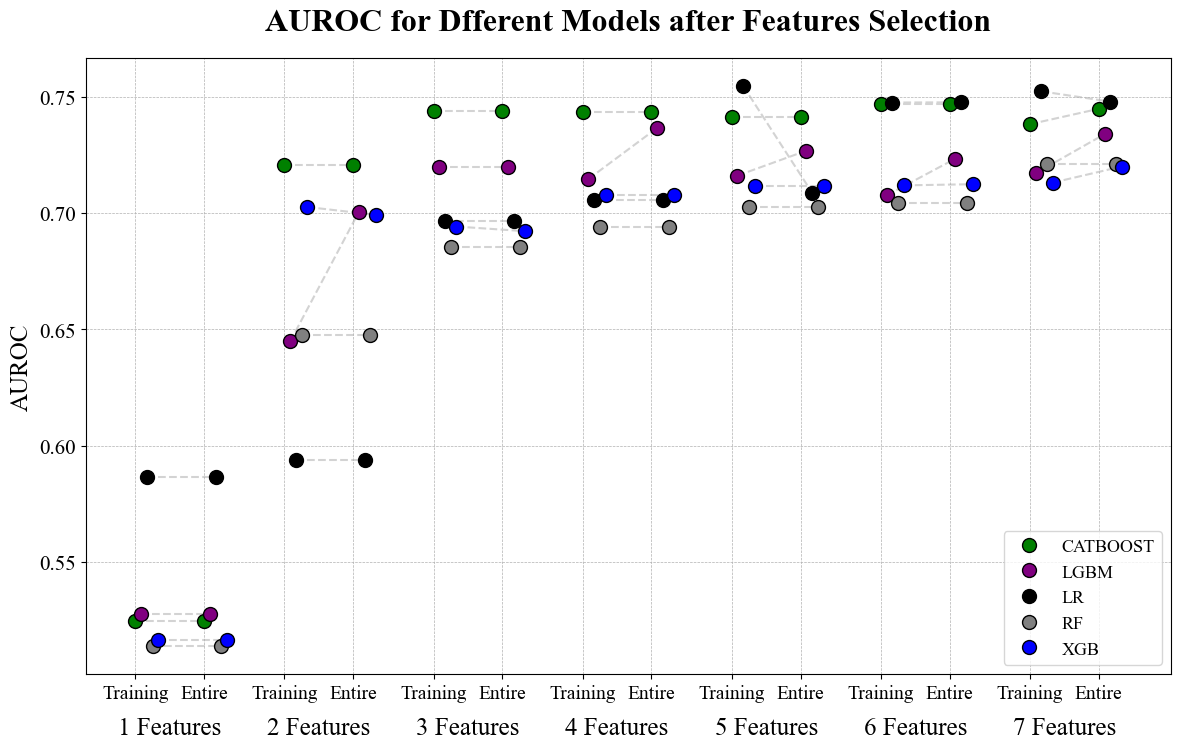

In [45]:
df4 = pd.read_csv('./evaluation_result/L1.2_result.csv', header=0)

# Extract the group number from the Method column and create separate columns for train and entire sets
df4['Group'] = df4['Method'].str.extract(r'(\d+)', expand=False)
df4['Set'] = df4['Method'].apply(lambda x: 'test' if 'test' in x else ('train' if 'train' in x else 'entire'))
# Select the required columns and pivot the dataframe
df_pivot = df4.pivot_table(index=['Group', 'Model'], columns='Set', values='ROC AUC').reset_index()

# Define new colors and markers for different models
models_reordered = df_pivot['Model'].unique()
colors_reordered = ['green', 'purple', 'black', 'grey', 'blue', 'yellow', 'orange',  'brown']
marker = 'o'
legend_labels = [model.upper() for model in models_reordered]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
plt.rcParams['font.family'] = 'Times New Roman'

# Define unique groups for grouping
groups = df_pivot['Group'].unique()

# Define the x positions for each group with some offset for train and entire sets
x_positions = {group: [i * 1.3, i * 1.3 + 0.6] for i, group in enumerate(groups)}

# Plot data for each model
for j, model in enumerate(models_reordered):
    for group in groups:
        feature_data_group = df_pivot[(df_pivot['Model'] == model) & (df_pivot['Group'] == group)]
        roc_auc_train = feature_data_group['train'].values
        roc_auc_entire = feature_data_group['entire'].values
        
        # Offset for minor separation within the group
        offset = j * 0.05
        
        # Plot lines to connect entire and train
        if len(roc_auc_train) > 0 and len(roc_auc_entire) > 0:
            ax.plot([x_positions[group][0] + offset, x_positions[group][1] + offset], [roc_auc_train[0], roc_auc_entire[0]], linestyle='--', color='lightgrey', zorder=1)
        
        # Plot points with larger size and black edge
        if len(roc_auc_train) > 0:
            ax.scatter(x_positions[group][0] + offset, roc_auc_train[0], marker=marker, color=colors_reordered[j], edgecolor='black', s=100, zorder=2)
        if len(roc_auc_entire) > 0:
            ax.scatter(x_positions[group][1] + offset, roc_auc_entire[0], marker=marker, color=colors_reordered[j], edgecolor='black', s=100, zorder=2)

# Set labels and title
# ax.set_xlabel('Groups', fontsize=14)
ax.set_ylabel('AUROC', fontsize=18)

ax.set_title('AUROC for Dfferent Models after Features Selection', fontsize=23, fontdict={'fontname': 'Times New Roman', 'fontweight': 'bold'},pad=20)

# Set custom x-ticks and labels
xtick_positions = [pos for positions in x_positions.values() for pos in positions]
xtick_labels = [label for group in groups for label in [f'Training', f'Entire']]
feature_labels = [f'{group} Features' for group in groups]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=14) # , rotation=45, ha='right'

for i, group in enumerate(groups):
    ax.text(i * 1.3 + 0.3, ax.get_ylim()[0] - 0.57, feature_labels[i], ha='center', va='top', fontsize=18, color='black', transform=ax.get_xaxis_transform())

# Create custom legend with uppercase labels
legend_elements = [
    plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor=colors_reordered[i], markeredgecolor='black', markersize=10, label=legend_labels[i])
    for i in range(len(models_reordered))
]
# ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0.5), fontsize=13) # , title='Models'
ax.legend(handles=legend_elements, loc='lower right', fontsize=13) # , title='Models'

ax.tick_params(axis='y', labelsize=15)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


## [L1.3] Duplicates in dataset

In [56]:
df = df_read.copy()
df = preprocess_data(df) # onehot

X_train, X_test, y_train, y_test = split_data_sgkf(df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3978, 14) (992, 14) (3978,) (992,)


In [57]:
for n in range(0, 101, 10):  # Iterate over percentages from 0% to 100%
    for model_name in models.keys():

        if n > 0:
            sample_size = int(len(X_test) * (n / 100))
            X_test_sample = X_test.sample(n=sample_size, replace=False, random_state=123)
            y_test_sample = y_test[X_test_sample.index]
            
            X_train_merged = pd.concat([X_train, X_test_sample], ignore_index=True)
            y_train_merged = np.concatenate([y_train, y_test_sample])
        else:
            X_train_merged = X_train
            y_train_merged = y_train

        fit_and_evaluate(X_train_merged, X_test, y_train_merged, y_test, methods=str(n), model_name=model_name, csv_filename='./evaluation_result/L1.3_duplicates.csv')


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 0, Model: lr
ROC AUC: 0.7436
'Method': 0, Model: knn
ROC AUC: 0.6139
'Method': 0, Model: svcrbf
ROC AUC: 0.6349
'Method': 0, Model: rf
ROC AUC: 0.7097
'Method': 0, Model: xgb
ROC AUC: 0.7126
'Method': 0, Model: lgbm
ROC AUC: 0.7213
'Method': 0, Model: catboost
ROC AUC: 0.7346
'Method': 0, Model: mlp
ROC AUC: 0.7184
'Method': 10, Model: lr
ROC AUC: 0.7438


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 10, Model: knn
ROC AUC: 0.638
'Method': 10, Model: svcrbf
ROC AUC: 0.6366
'Method': 10, Model: rf
ROC AUC: 0.7644
'Method': 10, Model: xgb
ROC AUC: 0.7352
'Method': 10, Model: lgbm
ROC AUC: 0.7496
'Method': 10, Model: catboost
ROC AUC: 0.7587
'Method': 10, Model: mlp
ROC AUC: 0.6801
'Method': 20, Model: lr
ROC AUC: 0.7437


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 20, Model: knn
ROC AUC: 0.6643
'Method': 20, Model: svcrbf
ROC AUC: 0.638
'Method': 20, Model: rf
ROC AUC: 0.8204
'Method': 20, Model: xgb
ROC AUC: 0.7879
'Method': 20, Model: lgbm
ROC AUC: 0.7796
'Method': 20, Model: catboost
ROC AUC: 0.7832
'Method': 20, Model: mlp
ROC AUC: 0.7213
'Method': 30, Model: lr
ROC AUC: 0.7442


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 30, Model: knn
ROC AUC: 0.6818
'Method': 30, Model: svcrbf
ROC AUC: 0.6393
'Method': 30, Model: rf
ROC AUC: 0.8539
'Method': 30, Model: xgb
ROC AUC: 0.8266
'Method': 30, Model: lgbm
ROC AUC: 0.8074
'Method': 30, Model: catboost
ROC AUC: 0.805
'Method': 30, Model: mlp
ROC AUC: 0.7307
'Method': 40, Model: lr
ROC AUC: 0.744


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 40, Model: knn
ROC AUC: 0.7017
'Method': 40, Model: svcrbf
ROC AUC: 0.6405
'Method': 40, Model: rf
ROC AUC: 0.8858
'Method': 40, Model: xgb
ROC AUC: 0.844
'Method': 40, Model: lgbm
ROC AUC: 0.8343
'Method': 40, Model: catboost
ROC AUC: 0.8249
'Method': 40, Model: mlp
ROC AUC: 0.7394
'Method': 50, Model: lr
ROC AUC: 0.744


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 50, Model: knn
ROC AUC: 0.7129
'Method': 50, Model: svcrbf
ROC AUC: 0.6419
'Method': 50, Model: rf
ROC AUC: 0.9145
'Method': 50, Model: xgb
ROC AUC: 0.8647
'Method': 50, Model: lgbm
ROC AUC: 0.8488
'Method': 50, Model: catboost
ROC AUC: 0.8403
'Method': 50, Model: mlp
ROC AUC: 0.7082
'Method': 60, Model: lr
ROC AUC: 0.7443


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 60, Model: knn
ROC AUC: 0.7343
'Method': 60, Model: svcrbf
ROC AUC: 0.6427
'Method': 60, Model: rf
ROC AUC: 0.9484
'Method': 60, Model: xgb
ROC AUC: 0.9119
'Method': 60, Model: lgbm
ROC AUC: 0.8846
'Method': 60, Model: catboost
ROC AUC: 0.8677
'Method': 60, Model: mlp
ROC AUC: 0.7336
'Method': 70, Model: lr
ROC AUC: 0.7442


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 70, Model: knn
ROC AUC: 0.7509
'Method': 70, Model: svcrbf
ROC AUC: 0.6438
'Method': 70, Model: rf
ROC AUC: 0.9667
'Method': 70, Model: xgb
ROC AUC: 0.9322
'Method': 70, Model: lgbm
ROC AUC: 0.9056
'Method': 70, Model: catboost
ROC AUC: 0.8803
'Method': 70, Model: mlp
ROC AUC: 0.7313
'Method': 80, Model: lr
ROC AUC: 0.7449


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 80, Model: knn
ROC AUC: 0.7752
'Method': 80, Model: svcrbf
ROC AUC: 0.6455
'Method': 80, Model: rf
ROC AUC: 0.9806
'Method': 80, Model: xgb
ROC AUC: 0.9488
'Method': 80, Model: lgbm
ROC AUC: 0.9242
'Method': 80, Model: catboost
ROC AUC: 0.9016
'Method': 80, Model: mlp
ROC AUC: 0.7003
'Method': 90, Model: lr
ROC AUC: 0.7454


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 90, Model: knn
ROC AUC: 0.8076
'Method': 90, Model: svcrbf
ROC AUC: 0.6469
'Method': 90, Model: rf
ROC AUC: 0.9952
'Method': 90, Model: xgb
ROC AUC: 0.9769
'Method': 90, Model: lgbm
ROC AUC: 0.9459
'Method': 90, Model: catboost
ROC AUC: 0.9243
'Method': 90, Model: mlp
ROC AUC: 0.7339
'Method': 100, Model: lr
ROC AUC: 0.7449


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': 100, Model: knn
ROC AUC: 0.826
'Method': 100, Model: svcrbf
ROC AUC: 0.6477
'Method': 100, Model: rf
ROC AUC: 1.0
'Method': 100, Model: xgb
ROC AUC: 0.9955
'Method': 100, Model: lgbm
ROC AUC: 0.9604
'Method': 100, Model: catboost
ROC AUC: 0.9338
'Method': 100, Model: mlp
ROC AUC: 0.7253


## [L2] Illegitimate features

In [65]:
file_name_bw = f"./preprocessing/df_tri2_12w28w_drop_death_train_bw.csv"
df_read_bw = f_read_file(file_name_bw)
print()
df_read_bw.count_id.unique().shape  # 4749


''' Select the coloums to be deleted'''
df_read_bw.drop(columns=['birth_weight', 'birth_ga'], inplace=True)
# df_read_bw.drop(columns=['birth_weight'], inplace=True)
# df_read_bw.drop(columns=['birth_ga'], inplace=True)

# df_read_bw.info()

=== Starting Reading === 
Index(['count_id', 'ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd',
       'm_age', 'placenta_cat', 'baby_gender', 'WHO_cur_sga', 'WHO_sga',
       'birth_ga', 'birth_weight'],
      dtype='object') 

The input data shape: 4970



In [66]:
df = df_read_bw.copy()
df = preprocess_data(df) # onehot
X_train, X_test, y_train, y_test = split_data_sgkf(df)

cols_to_standardize = ['ga', 'efw', 'bpd', 'hc', 'ac', 'fl', 'nf', 'cm', 'tcd', 'm_age'] # 'birth_ga', 'birth_weight', 
illegal_feature = 'birth_weight&ga' # None, birth_ga, birth_weight, birth_weight&ga

for model_name in models.keys():

    X_train_standardized = df_standardize(X_train.copy(), cols_to_standardize, 'zscore')
    X_test_standardized = df_standardize_test(X_test.copy(), cols_to_standardize, 'zscore')
        
    fit_and_evaluate(X_train_standardized, X_test_standardized, y_train, y_test, methods=illegal_feature, model_name=model_name, csv_filename='./evaluation_result/L2_illegimate.csv')


sgkf - Number of common 'count_id' values between train and test sets: 0
'Method': birth_ga, Model: lr
ROC AUC: 0.9434
'Method': birth_ga, Model: knn
ROC AUC: 0.9002
'Method': birth_ga, Model: svcrbf
ROC AUC: 0.9499
'Method': birth_ga, Model: rf
ROC AUC: 0.9473
'Method': birth_ga, Model: xgb
ROC AUC: 0.942
'Method': birth_ga, Model: lgbm
ROC AUC: 0.9453
'Method': birth_ga, Model: catboost
ROC AUC: 0.9501
'Method': birth_ga, Model: mlp
ROC AUC: 0.9487


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## [L3] Non-independent

In [60]:
def split_data_sgkf(df):
    X = df.drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id'])
    y = df['WHO_sga']    
    count_id = df.count_id

    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=123)
    train_index, test_index = next(sgkf.split(X, y, groups=count_id))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    count_id_train, count_id_test = count_id.iloc[train_index], count_id.iloc[test_index]
    common_count_ids = set(count_id_train).intersection(set(count_id_test))
    print(f"sgkf - Number of common 'count_id' values between train and test sets: {len(common_count_ids)}")

    return X_train, X_test, y_train, y_test


def split_data_skf(df):
    X = df.drop(columns=['WHO_sga', 'WHO_cur_sga', 'count_id'])
    y = df['WHO_sga']
    count_id = df.count_id

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    train_index, test_index = next(skf.split(X, y))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    count_id_train, count_id_test = count_id.iloc[train_index], count_id.iloc[test_index]
    common_count_ids = set(count_id_train).intersection(set(count_id_test))
    print(f"skf -Number of common 'count_id' values between train and test sets: {len(common_count_ids)}")

    return X_train, X_test, y_train, y_test

In [61]:
df = df_read.copy()
df = preprocess_data(df) # onehot

split_methods = {
    'sgkf' : split_data_sgkf,
    'skf' : split_data_skf
}

for split_methond_name, split_methond in split_methods.items():

    X_train, X_test, y_train, y_test = split_methond(df)

    
    for model_name in models: # .keys()
        
        fit_and_evaluate(X_train, X_test, y_train, y_test, methods=split_methond_name, model_name=model_name, csv_filename='./evaluation_result/L3_nonindependent.csv')


sgkf - Number of common 'count_id' values between train and test sets: 0
'Method': sgkf, Model: lr
ROC AUC: 0.7436


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': sgkf, Model: knn
ROC AUC: 0.6139
'Method': sgkf, Model: svcrbf
ROC AUC: 0.6349
'Method': sgkf, Model: rf
ROC AUC: 0.7097
'Method': sgkf, Model: xgb
ROC AUC: 0.7126
'Method': sgkf, Model: lgbm
ROC AUC: 0.7213
'Method': sgkf, Model: catboost
ROC AUC: 0.7346
'Method': sgkf, Model: mlp
ROC AUC: 0.7184
skf -Number of common 'count_id' values between train and test sets: 67
'Method': skf, Model: lr
ROC AUC: 0.7332


d:\anaconda3_2024\envs\python2024\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Method': skf, Model: knn
ROC AUC: 0.6211
'Method': skf, Model: svcrbf
ROC AUC: 0.6043
'Method': skf, Model: rf
ROC AUC: 0.7186
'Method': skf, Model: xgb
ROC AUC: 0.7124
'Method': skf, Model: lgbm
ROC AUC: 0.716
'Method': skf, Model: catboost
ROC AUC: 0.7445
'Method': skf, Model: mlp
ROC AUC: 0.6883


### evaluate

In [ ]:
results_df = pd.read_csv('./evaluation_result/L3_nonindependent.csv')

evalu = 'ROC AUC'
def filter_rows(df):
    sgkf_row = df[df['Method'] == 'sgkf']
    skf_row = df[df['Method'] == 'skf']
    if not sgkf_row.empty and not skf_row.empty:
        if skf_row[evalu].values[0] > sgkf_row[evalu].values[0]:
            return pd.concat([sgkf_row, skf_row])
    return pd.DataFrame()

# Apply the function to each group
filtered_df = results_df.groupby('Model').apply(filter_rows).reset_index(drop=True)
filtered_df

# RESULT

In [ ]:
results_df = pd.read_csv('./evaluation_result/model_evaluation_results.csv')
results_df